### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns

### Load Dataset

In [2]:
def load_and_preprocess_images(folder_path, subfolders, image_size=(224, 224)):
    
    # Create a mapping from subfolder names to label indices
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    
    # Prepare lists to hold images and labels
    images = []
    labels = []
    
    # Iterate over each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize the image to the target size
                img_resized = cv2.resize(img, image_size)
                images.append(img_resized)
                labels.append(label_map[subfolder])
    
    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Normalize the images
    images = images.astype('float32') / 255.0
    
    return images, labels


In [3]:
train_path = "/kaggle/input/fruits-classification/Fruits Classification/train"
test_path = "/kaggle/input/fruits-classification/Fruits Classification/test"
valid_path = "/kaggle/input/fruits-classification/Fruits Classification/valid"

subfolders = ['Apple', 'Banana', 'Grape', 'Mango','Strawberry']

x_train, y_train = load_and_preprocess_images(train_path, subfolders)
x_test , y_test = load_and_preprocess_images(test_path, subfolders)
x_valid, y_valid = load_and_preprocess_images(valid_path, subfolders)

In [4]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_valid.shape,y_valid.shape)

(9700, 224, 224, 3) (9700,)
(100, 224, 224, 3) (100,)
(200, 224, 224, 3) (200,)


### Visualization

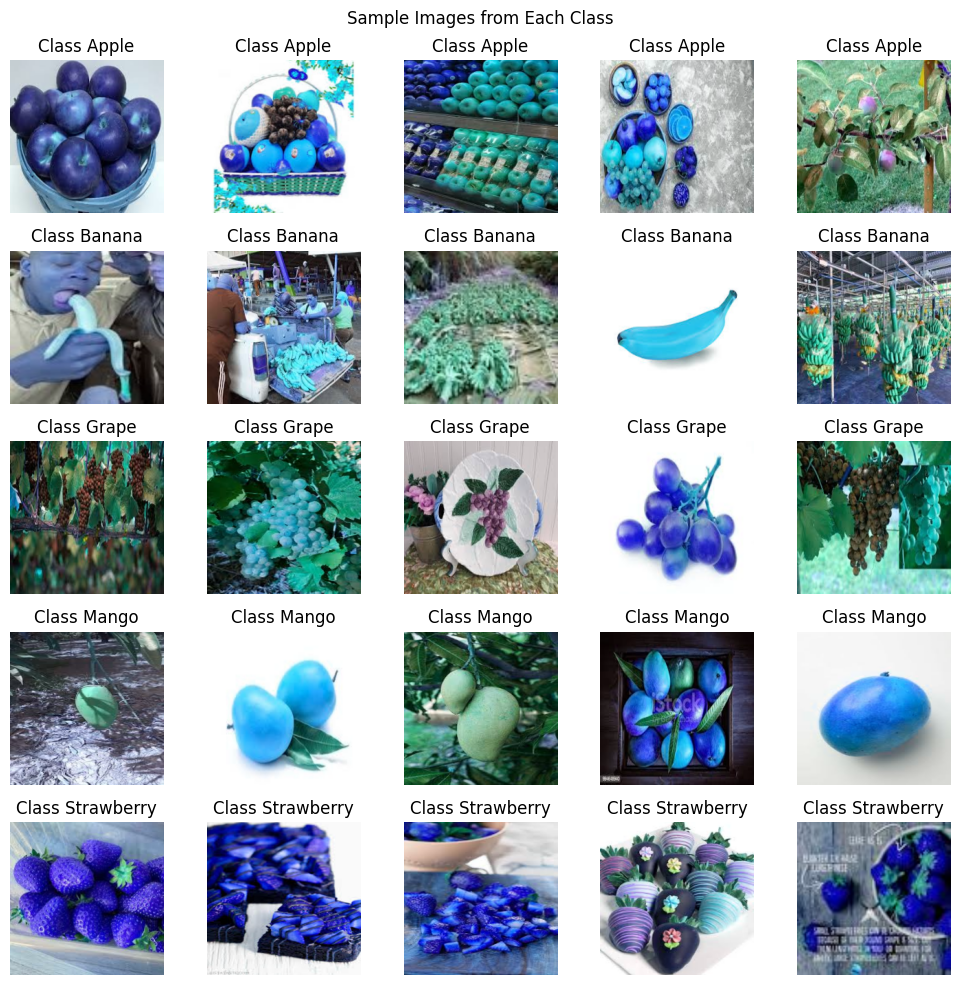

In [5]:
# Plot 5 images for each class
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(y_train == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i * 5 + j + 1)
        plt.imshow(x_train[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.tight_layout()
plt.show()

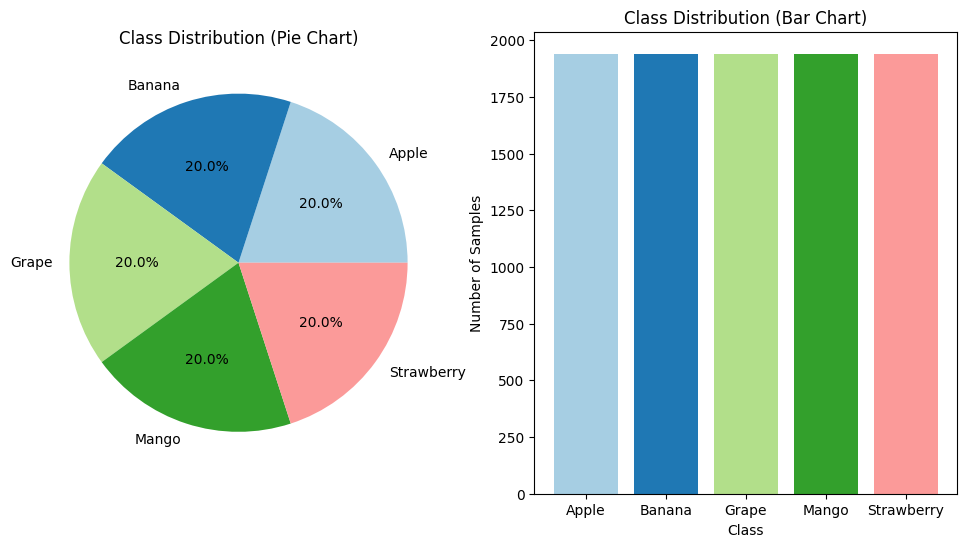

In [6]:
# Plot class distribution as a pie and bar chart
class_counts = np.bincount(y_train)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(class_counts, labels=subfolders, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
plt.bar(subfolders, class_counts, color=plt.cm.Paired.colors)
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.show()

In [7]:
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(subfolders))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(subfolders))
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=len(subfolders))

In [8]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_valid.shape,y_valid.shape)

(9700, 224, 224, 3) (9700, 5)
(100, 224, 224, 3) (100, 5)
(200, 224, 224, 3) (200, 5)


In [9]:
from sklearn.utils import shuffle

# Shuffle the training and validation data
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_valid,y_valid = shuffle (x_valid,y_valid , random_state = 42)

In [10]:
print(y_train[:20])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


### Building Model

In [11]:
# Build the CNN model with Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after first pooling layer

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after second pooling layer

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # Add Dropout before final dense layer

    tf.keras.layers.Dense(len(subfolders), activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,986,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,006,437 (11.47 MB)

 Trainable params: 3,006,437 (11.47 MB)

 Non-trainable params: 0 (0.00 B)

None


### Training

In [14]:
# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=6, validation_data=(x_valid, y_valid),batch_size=128)

Epoch 1/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 580s 8s/step - accuracy: 0.2609 - loss: 2.1853 - val_accuracy: 0.4100 - val_loss: 1.3387
Epoch 2/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 580s 8s/step - accuracy: 0.4603 - loss: 1.2945 - val_accuracy: 0.4350 - val_loss: 1.2849
Epoch 3/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 552s 7s/step - accuracy: 0.5390 - loss: 1.1335 - val_accuracy: 0.4600 - val_loss: 1.1893
Epoch 4/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 575s 8s/step - accuracy: 0.5838 - loss: 1.0171 - val_accuracy: 0.5100 - val_loss: 1.1299
Epoch 5/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 614s 7s/step - accuracy: 0.6196 - loss: 0.9338 - val_accuracy: 0.5800 - val_loss: 1.0739
Epoch 6/6
76/76 ━━━━━━━━━━━━━━━━━━━━ 568s 7s/step - accuracy: 0.6615 - loss: 0.8567 - val_accuracy: 0.5750 - val_loss: 1.0804


### Evaluate Model 

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.5534 - loss: 1.2633
Test accuracy: 0.6100000143051147
Test loss: 1.0906257629394531


In [16]:
# Classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
              precision    recall  f1-score   support

       Apple       0.56      0.25      0.34        20
      Banana       0.55      0.60      0.57        20
       Grape       0.78      0.70      0.74        20
       Mango       0.67      0.60      0.63        20
  Strawberry       0.55      0.90      0.68        20

    accuracy                           0.61       100
   macro avg       0.62      0.61      0.59       100
weighted avg       0.62      0.61      0.59       100



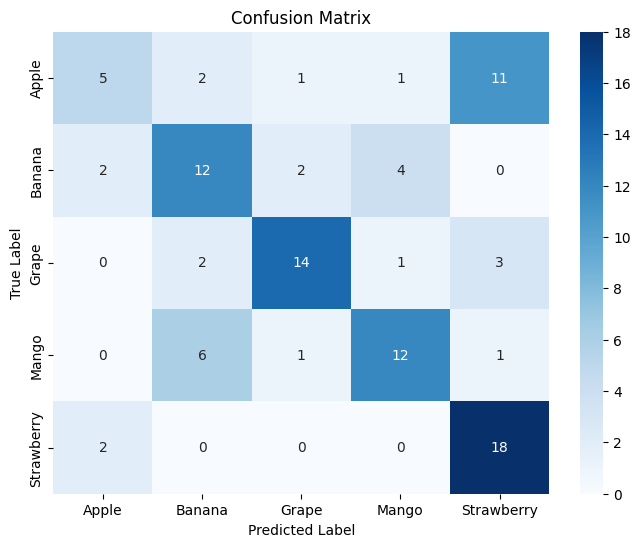

In [17]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Plotting History 

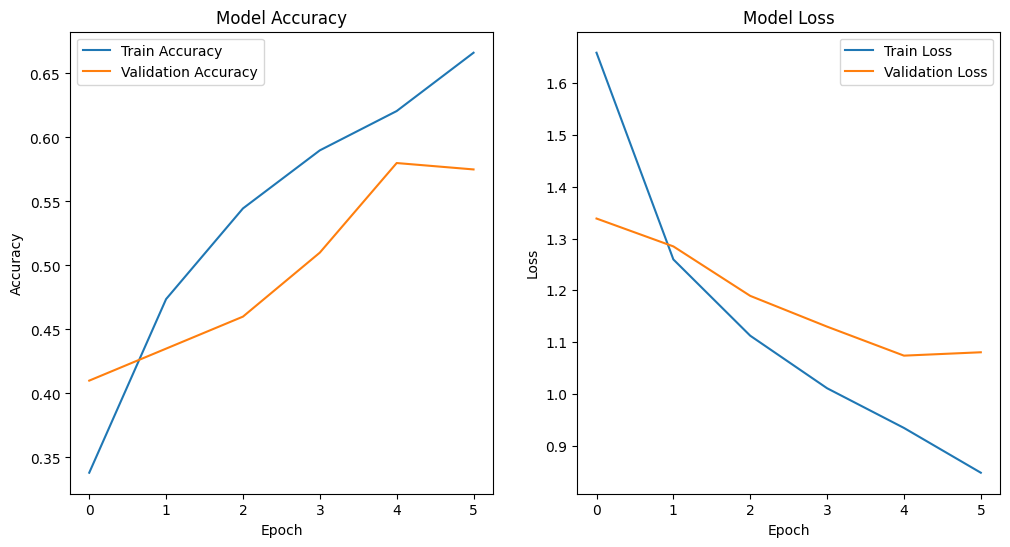

In [18]:
# Plot the history of model accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Model Testing 

In [19]:
# Function to predict and display results for multiple images
def predict_and_display_results(model, images, true_labels, subfolders, num_images=4):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_images):
        # Select a random image from the test set
        index = np.random.randint(0, len(images))
        sample_image = images[index]
        true_label = np.argmax(true_labels[index])

        # Predict the probabilities for the selected image
        predictions = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_label = np.argmax(predictions[0])

        # Format and print the probabilities with their corresponding labels
        formatted_probabilities = [f'Label {subfolders[i]}: {prob:.4f}' for i, prob in enumerate(predictions[0])]

        # Print the true label, predicted label, and all probabilities
        print(f'Image {i+1}:')
        print(f'True label: {subfolders[true_label]}')
        print(f'Predicted label: {subfolders[predicted_label]}')
        print('Probabilities for each class:')
        for label_prob in formatted_probabilities:
            print(label_prob)
        print()

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_image)
        plt.title(f'True: {subfolders[true_label]}\nPredicted: {subfolders[predicted_label]}')
        plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 1:
True label: Grape
Predicted label: Grape
Probabilities for each class:
Label Apple: 0.0062
Label Banana: 0.0319
Label Grape: 0.9224
Label Mango: 0.0081
Label Strawberry: 0.0314

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 2:
True label: Banana
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.2405
Label Banana: 0.3873
Label Grape: 0.1341
Label Mango: 0.1907
Label Strawberry: 0.0474

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image 3:
True label: Apple
Predicted label: Strawberry
Probabilities for each class:
Label Apple: 0.2294
Label Banana: 0.0526
Label Grape: 0.2128
Label Mango: 0.0294
Label Strawberry: 0.4758



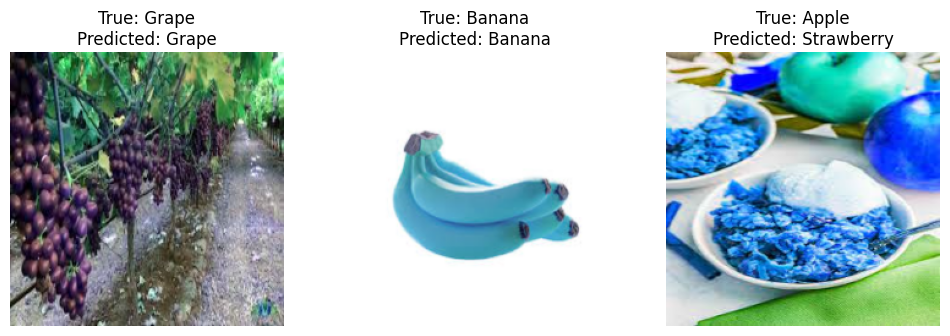

In [25]:
# Test the function with 4 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 1:
True label: Banana
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.0885
Label Banana: 0.3785
Label Grape: 0.2530
Label Mango: 0.2698
Label Strawberry: 0.0103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 2:
True label: Banana
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.1349
Label Banana: 0.7124
Label Grape: 0.0323
Label Mango: 0.1180
Label Strawberry: 0.0025



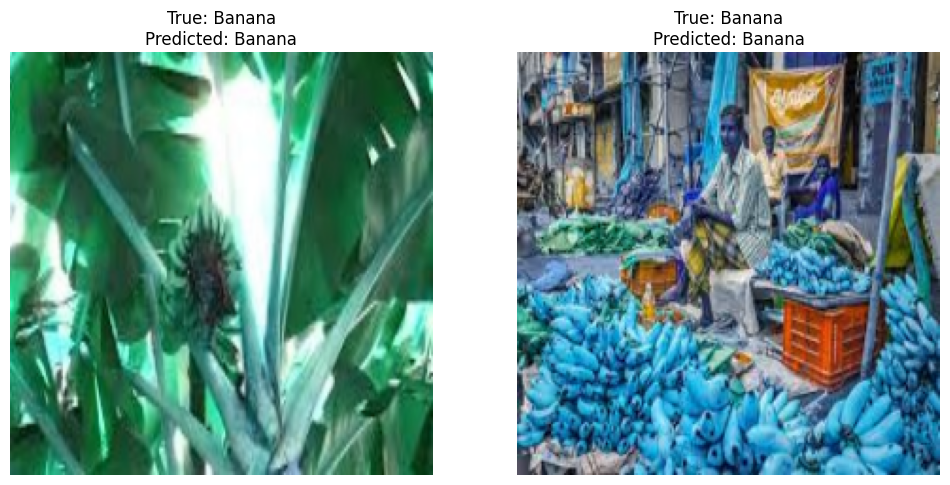

In [21]:
# Test the function with 2 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 1:
True label: Mango
Predicted label: Mango
Probabilities for each class:
Label Apple: 0.1623
Label Banana: 0.1793
Label Grape: 0.2219
Label Mango: 0.2315
Label Strawberry: 0.2050



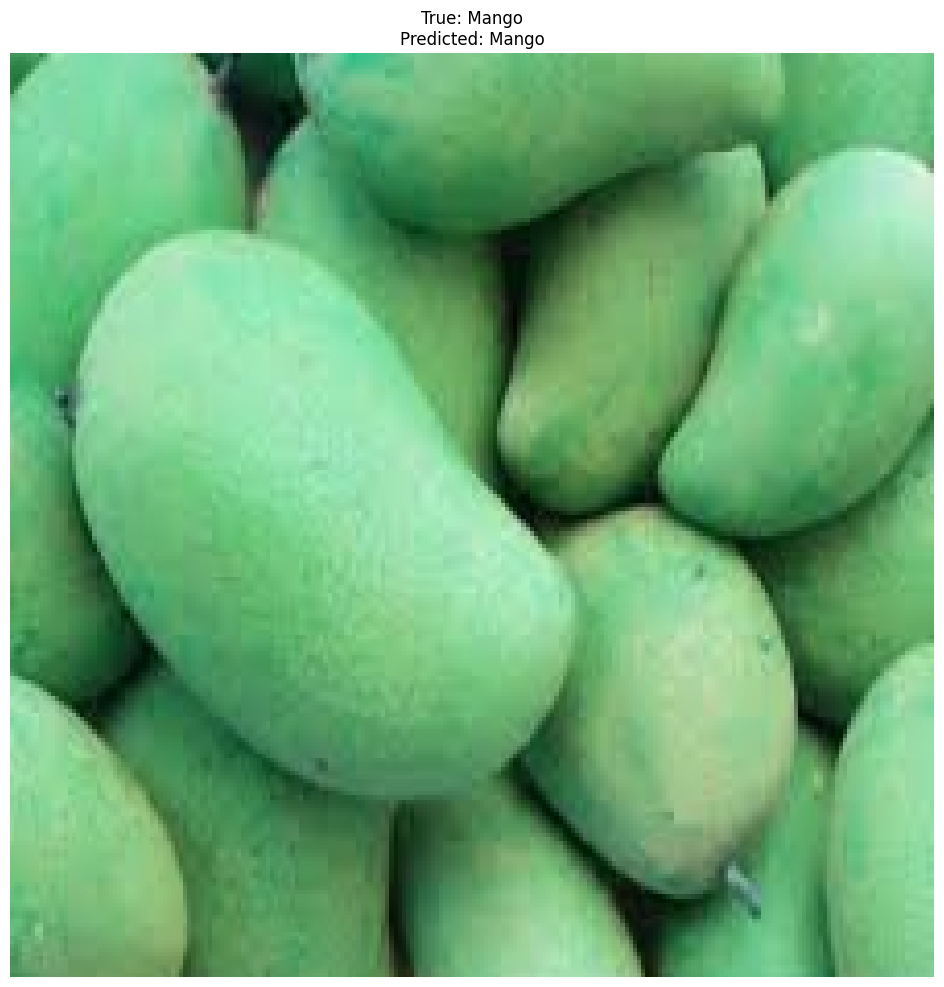

In [22]:
# Test the function with 1 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 1:
True label: Strawberry
Predicted label: Strawberry
Probabilities for each class:
Label Apple: 0.0650
Label Banana: 0.0020
Label Grape: 0.0151
Label Mango: 0.0013
Label Strawberry: 0.9167

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 2:
True label: Apple
Predicted label: Strawberry
Probabilities for each class:
Label Apple: 0.0262
Label Banana: 0.0000
Label Grape: 0.0275
Label Mango: 0.0018
Label Strawberry: 0.9445

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 3:
True label: Apple
Predicted label: Apple
Probabilities for each class:
Label Apple: 0.3603
Label Banana: 0.2894
Label Grape: 0.1303
Label Mango: 0.1962
Label Strawberry: 0.0238

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 4:
True label: Mango
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.0841
Label Banana: 0.5290
Label Grape: 0.0656
Label Mango: 0.3109
Label Strawberry: 0.0103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image 5:
True label: Apple
Predicted label: Ma

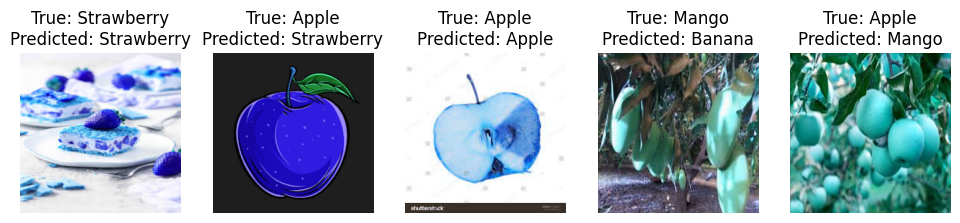

In [23]:
# Test the function with 5 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 1:
True label: Mango
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.0273
Label Banana: 0.8593
Label Grape: 0.0087
Label Mango: 0.1047
Label Strawberry: 0.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 2:
True label: Banana
Predicted label: Banana
Probabilities for each class:
Label Apple: 0.2413
Label Banana: 0.2849
Label Grape: 0.2110
Label Mango: 0.2610
Label Strawberry: 0.0018

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 3:
True label: Apple
Predicted label: Apple
Probabilities for each class:
Label Apple: 0.3603
Label Banana: 0.2894
Label Grape: 0.1303
Label Mango: 0.1962
Label Strawberry: 0.0238



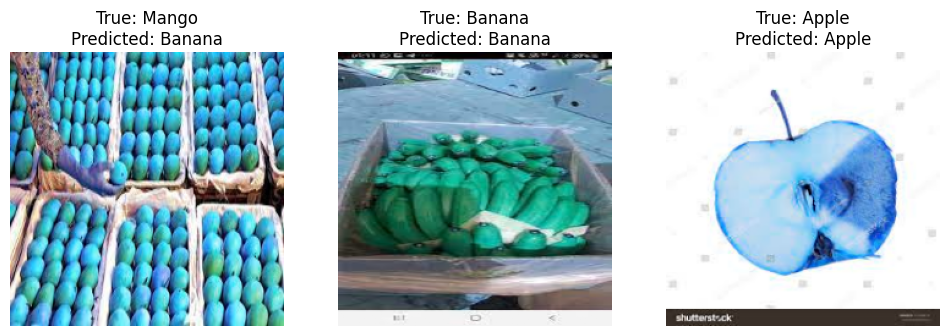

In [24]:
# Test the function with 3 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=3)